## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
!pip install -r requirements.txt

  Using cached CFEDemands-0.5.4-py2.py3-none-any.whl (47 kB)
  Using cached gspread-5.8.0-py3-none-any.whl (40 kB)
  Using cached gspread_pandas-3.2.2-py2.py3-none-any.whl (26 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
  Using cached python_gnupg-0.5.0-py2.py3-none-any.whl (18 kB)
  Using cached ConsumerDemands-0.4.1.dev0-py2.py3-none-any.whl (12 kB)
  Using cached xarray-2023.4.2-py3-none-any.whl (979 kB)
  Using cached dvc-2.55.0-py3-none-any.whl (419 kB)
  Using cached ray-2.4.0-cp39-cp39-manylinux2014_x86_64.whl (58.6 MB)
  Using cached pandas-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached dvc_render-0.3.1-py3-none-any.whl (18 kB)
  Using cached configobj-5.0.8-py2.py3-none-any.whl (36 kB)
  Using cached iterative_telemetry-0.0.8-py3-none-any.whl (10 kB)
  Using cached flatten_dict-0.4.2-py2.py3-none-an

  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached sqltrie-0.3.1-py3-none-any.whl (16 kB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached dvc_objects-0.21.2-py3-none-any.whl (37 kB)
  Using cached diskcache-5.6.1-py3-none-any.whl (45 kB)
  Using cached dictdiffer-0.9.0-py2.py3-none-any.whl (16 kB)
  Using cached nanotime-0.5.2-py3-none-any.whl
  Using cached aiohttp_retry-2.8.3-py3-none-any.whl (9.8 kB)
  Using cached dulwich-0.21.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (505 kB)
  Using cached kombu-5.2.4-py3-none-any.whl (189 kB)
  Using cached celery-5.2.7-py3-none-any.whl (405 kB)
  Using cached atpublic-3.1.1-py3-none-any.whl (4.8 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
  Using cached asyncssh-2.13.1-py3-none-any.whl (

  Using cached orjson-3.8.10-cp39-cp39-manylinux_2_28_x86_64.whl (140 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2021.1
    Uninstalling pytz-2021.1:
      Successfully uninstalled pytz-2021.1
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.1
    Uninstalling tqdm-4.62.1:
      Successfully uninstalled tqdm-4.62.1
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.0
    Uninstalling python-dateutil-2.8.0:
      Successfully uninstalled python-dateutil-2.8.0
  Attempting uninstall: pathspec
    Found existing installation: pathspec 0.9.0
    Uninstalling pathspec-0.9.0:
      Successfully uninstalled pathspec-0.9.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: attrs
    Found existing installation: attrs 19.3.0
    

In [2]:
import pandas as pd
import cfe.regression as rgsn

Missing dependencies for OracleDemands.


### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Andhra Pradesh (AP):



In [3]:
InputFiles = {'FCT':('13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo','FCT'),
              'RDI':('11BaFWcBzgwUUhaJkNh4t-mdV1yf_OJioFtUHDH9xIeY','RDI'),}

#### Prices, FCT, RDI



In [4]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [5]:
import pyarrow.parquet as pq

# Get prices 
p = pq.read_table(source='ap68_prices.parquet').to_pandas()
p.reset_index(level='unit', drop=True, inplace=True)
p

,p
i,
apple,11.111111
arhar (tur),15.384615
baby food,3.846154
bajra & products,83.333333
banana,0.483333
...,...
walnut,3.333333
watermelon,75.000000
wheat/atta - P.D.S.,151.515152


#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for AP:



In [6]:
r = rgsn.read_pickle('ap68.pickle')  # Assumes you've already set this up e.g., in Project 3

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.


In [7]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p # Prof Ligon provided what are presumably already average prices 
pbar = pbar.loc[r.beta.index] # Only use prices for goods we can estimate
pbar = pbar.iloc[:,0]
pbar

j
banana                          0.483333
bidi                            3.000000
brinjal                        55.555556
cabbage                        62.500000
chillis (green)                25.000000
cigarettes                      0.333333
dry chillies                    8.333333
eggs                            0.285714
electricity                     0.333333
firewood & chips              333.333333
garlic                         12.500000
ginger                         20.000000
kerosene-other sources         33.333333
lady's finger                  45.454545
matches                         1.000000
milk: liquid                   40.000000
moong                          14.285714
onion                          66.666667
other spices                    5.000000
potato                         83.333333
rice - other sources           48.780488
salt                           93.750000
sugar - other sources          30.303030
tea : cups                      0.219178
tea : leaf    

#### Budgets



Get food budget for all households, then find median budget:



In [8]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [9]:
xref

1934.9326723987629

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [10]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,banana,bidi,brinjal,cabbage,chillis (green),cigarettes,dry chillies,eggs,electricity,firewood & chips,...,other spices,potato,rice - other sources,salt,sugar - other sources,tea : cups,tea : leaf,tomato,turmeric,wheat/atta - other sources
i,t,m,,,,,,,,,,,,,,,,,,,,,
420001101,68,Andhra Pradesh,56.881380,19.215585,0.186594,0.156057,0.254517,427.999639,1.836724,61.722093,668.112129,0.448199,...,1.962559,0.119920,10.460658,0.105580,1.979743,215.425760,3.995931,0.289397,1.354737,1.066827
420001102,68,Andhra Pradesh,76.744402,23.841108,0.282432,0.225796,0.338580,377.891335,2.472629,95.148474,1141.891769,0.601561,...,2.286904,0.175634,21.387701,0.181986,3.952930,243.902096,6.390390,0.434173,1.701488,1.885127
420001201,68,Andhra Pradesh,34.405796,12.300733,0.148714,0.135080,0.173354,141.932121,1.002778,68.145066,521.063058,0.425147,...,0.888339,0.098909,12.054615,0.117815,1.678825,157.391061,2.891609,0.210501,0.734741,0.767163
420001202,68,Andhra Pradesh,52.381480,17.740044,0.183522,0.150936,0.237855,239.104784,1.650268,70.521134,597.064652,0.576757,...,1.627982,0.123955,12.226214,0.133685,2.161326,185.058952,3.638507,0.280109,1.150185,1.039660
420001203,68,Andhra Pradesh,41.879889,11.758183,0.156754,0.141106,0.194832,152.880399,1.191670,67.259124,559.162126,0.521546,...,1.117277,0.108839,12.698225,0.137998,2.127037,180.483541,3.466451,0.240077,0.896652,0.961316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758991202,68,Andhra Pradesh,26.820331,9.213891,0.110868,0.094985,0.132188,111.873863,0.727758,45.800150,230.551989,0.384864,...,0.723845,0.073301,6.493550,0.072159,0.862013,104.167675,2.022698,0.160482,0.563117,0.319208
758991301,68,Andhra Pradesh,28.520690,10.681366,0.129774,0.104232,0.149881,127.839470,0.826892,57.528892,294.063084,0.447240,...,0.653290,0.081818,9.533859,0.096048,1.248917,108.305987,2.454000,0.181700,0.612019,0.421210
758992101,68,Andhra Pradesh,41.956722,15.019898,0.264649,0.202256,0.346081,149.949686,1.938871,120.667534,415.697023,0.981066,...,1.501116,0.185983,22.249621,0.230923,2.895983,264.562829,5.538869,0.343474,1.147826,1.220132


Finally, define a function to change a single price in the vector $p$:



In [11]:
def my_prices(p0,p=pbar,j='banana'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [12]:
r.demands(xref,pbar)

j
banana                        10.046497
bidi                           4.127658
brinjal                        1.786564
cabbage                        1.608802
chillis (green)                2.499510
cigarettes                    36.395714
dry chillies                   5.242458
eggs                           3.879660
electricity                    7.041535
firewood & chips               1.049927
garlic                         3.130112
ginger                         2.926156
kerosene-other sources         1.693840
lady's finger                  1.948109
matches                        1.636133
milk: liquid                   2.234305
moong                          2.949783
onion                          1.665851
other spices                   6.658903
potato                         1.587053
rice - other sources           1.778151
salt                           1.477361
sugar - other sources          2.621531
tea : cups                     4.535861
tea : leaf                     3.83339

<IPython.core.display.Javascript object>


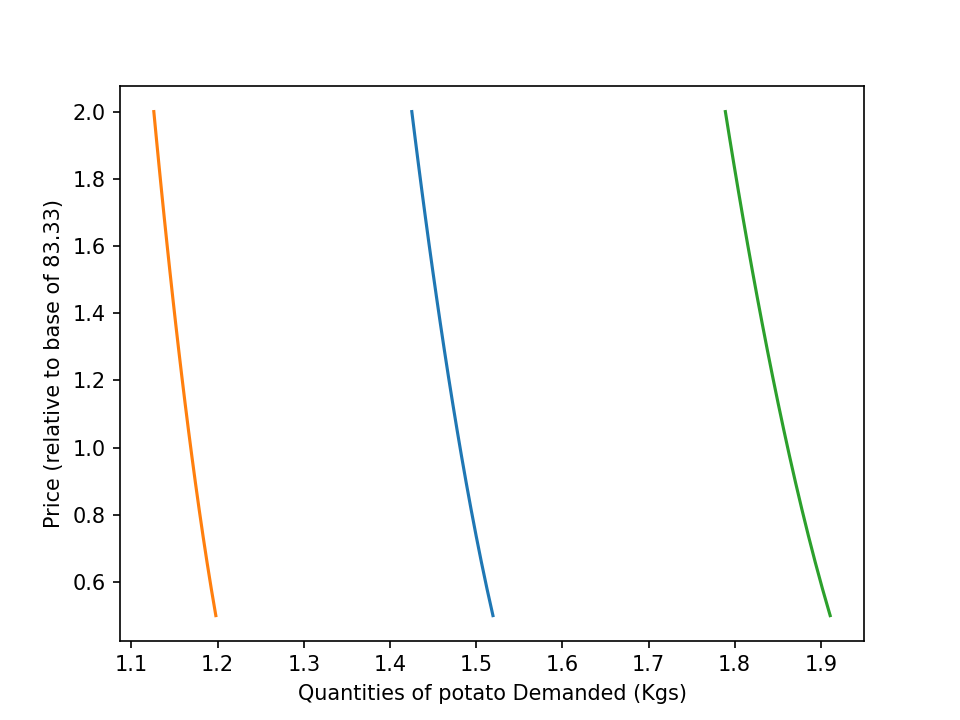

Text(0.5, 0, 'Quantities of potato Demanded (Kgs)')

In [27]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'potato'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for [food] for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for [food] for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for [food] for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded (Kgs)")

#### Engel Curves



<IPython.core.display.Javascript object>


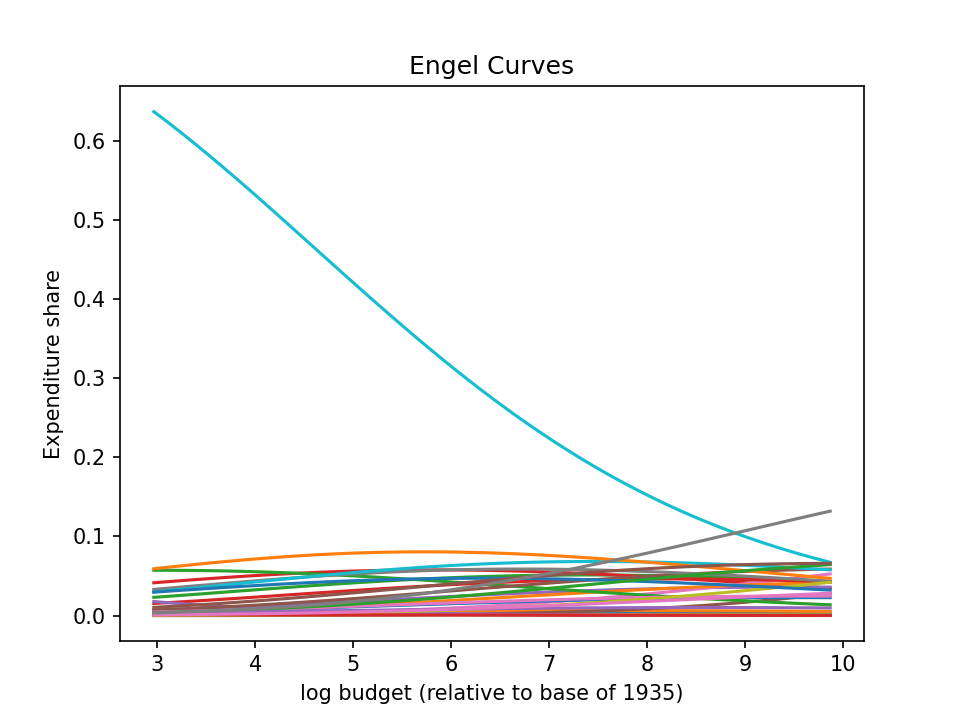

/opt/conda/lib/python3.9/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.16E-10.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/opt/conda/lib/python3.9/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.46E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


Text(0.5, 1.0, 'Engel Curves')

In [14]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [15]:
fct.index = fct.index.str.lower()
fct

n,Protein,Fat,Calories,Calcium,Iron,Betacarotene,Thiamine,Riboflavin,Niacin,Ascorbic Acid
j,,,,,,,,,,
rice,78.099998,5.500000,3513.423096,81.099998,7.200000,0.000000,1.700000,0.600000,25.100000,0.00000
wheat,105.800003,15.000000,3208.894531,351.500000,40.349998,28.500000,4.400000,1.500000,25.250000,0.00000
jowar/sorghum,99.700005,17.299999,3339.065430,276.000000,39.500000,82.900002,3.500000,1.400000,21.000000,0.00000
bajra/pearl millet,102.699997,51.399998,2987.166016,258.933319,60.766663,267.266663,2.366667,1.900000,8.133333,0.00000
maize,88.000000,37.700001,3339.065430,89.099998,24.900000,1860.000000,3.300000,0.900000,26.900002,0.00000
...,...,...,...,...,...,...,...,...,...,...
coffee,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
meals,10.000000,1.670000,333.000000,0.000000,2.400000,0.000000,0.000000,0.000000,0.000000,0.00000
complete meals in hotel,10.000000,1.670000,333.000000,0.000000,2.400000,0.000000,0.000000,0.000000,0.000000,0.00000


In [16]:
# Guesstimate to match more labels between fct and qhat 
qhat_to_fct = {"chillis (green)": "chillies",
               "milk: liquid": "milk",
               "moong": "greengram (mung)", 
               "rice - other sources": "rice", 
               "sugar - other sources" : "sugar", 
               "tea : cups": "tea",
               "wheat/atta - other sources": "wheat"
}

qhat.rename(qhat_to_fct, axis='columns', inplace=True)
qhat

,,j,banana,bidi,brinjal,cabbage,chillies,cigarettes,dry chillies,eggs,electricity,firewood & chips,...,other spices,potato,rice,salt,sugar,tea,tea : leaf,tomato,turmeric,wheat
i,t,m,,,,,,,,,,,,,,,,,,,,,
420001101,68,Andhra Pradesh,56.881380,19.215585,0.186594,0.156057,0.254517,427.999639,1.836724,61.722093,668.112129,0.448199,...,1.962559,0.119920,10.460658,0.105580,1.979743,215.425760,3.995931,0.289397,1.354737,1.066827
420001102,68,Andhra Pradesh,76.744402,23.841108,0.282432,0.225796,0.338580,377.891335,2.472629,95.148474,1141.891769,0.601561,...,2.286904,0.175634,21.387701,0.181986,3.952930,243.902096,6.390390,0.434173,1.701488,1.885127
420001201,68,Andhra Pradesh,34.405796,12.300733,0.148714,0.135080,0.173354,141.932121,1.002778,68.145066,521.063058,0.425147,...,0.888339,0.098909,12.054615,0.117815,1.678825,157.391061,2.891609,0.210501,0.734741,0.767163
420001202,68,Andhra Pradesh,52.381480,17.740044,0.183522,0.150936,0.237855,239.104784,1.650268,70.521134,597.064652,0.576757,...,1.627982,0.123955,12.226214,0.133685,2.161326,185.058952,3.638507,0.280109,1.150185,1.039660
420001203,68,Andhra Pradesh,41.879889,11.758183,0.156754,0.141106,0.194832,152.880399,1.191670,67.259124,559.162126,0.521546,...,1.117277,0.108839,12.698225,0.137998,2.127037,180.483541,3.466451,0.240077,0.896652,0.961316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758991202,68,Andhra Pradesh,26.820331,9.213891,0.110868,0.094985,0.132188,111.873863,0.727758,45.800150,230.551989,0.384864,...,0.723845,0.073301,6.493550,0.072159,0.862013,104.167675,2.022698,0.160482,0.563117,0.319208
758991301,68,Andhra Pradesh,28.520690,10.681366,0.129774,0.104232,0.149881,127.839470,0.826892,57.528892,294.063084,0.447240,...,0.653290,0.081818,9.533859,0.096048,1.248917,108.305987,2.454000,0.181700,0.612019,0.421210
758992101,68,Andhra Pradesh,41.956722,15.019898,0.264649,0.202256,0.346081,149.949686,1.938871,120.667534,415.697023,0.981066,...,1.501116,0.185983,22.249621,0.230923,2.895983,264.562829,5.538869,0.343474,1.147826,1.220132


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [17]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['rice', 'wheat', 'greengram (mung)', 'milk', 'sugar', 'eggs', 'potato',
       'onion', 'tomato', 'brinjal', 'chillies', 'cabbage', 'banana',
       'other spices', 'tea'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [18]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,420001101,420001102,420001201,420001202,420001203,420001204,420001301,420001302,420011101,420011102,...,758982201,758982202,758982301,758991101,758991201,758991202,758991301,758992101,758992201,758992202
t,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
m,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,...,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh,Andhra Pradesh
n,,,,,,,,,,,,,,,,,,,,,
Protein,3290.116855,5612.572736,3101.206160,3575.574280,3330.874952,3479.912159,2234.976269,2616.795797,3615.141498,3711.097262,...,3184.744657,2220.701458,2103.100739,2970.092010,2443.513715,1928.049535,2503.344318,5462.610245,1878.409612,2092.449560
Fat,1602.810960,2879.326880,1445.793805,1700.636531,1669.674450,1802.650633,1115.672843,1266.365998,1834.405622,1884.751932,...,1446.398987,1007.343569,955.247459,1344.982859,1106.601120,873.453210,1145.442546,2517.302192,867.044448,981.045269
Calories,86500.336501,156947.659790,82152.106250,94057.825131,90537.153251,91726.787065,57040.587185,69235.903552,96356.050071,99402.182789,...,83218.683044,56325.369168,52645.663369,77807.749387,63685.685413,48075.869567,64888.660989,144815.518435,47278.937655,52486.159082
Calcium,27044.161556,48343.170468,20817.435512,26773.201598,25867.882921,28833.133142,17235.108845,18571.205574,30480.290027,31130.256211,...,20667.762231,14877.940592,13026.059335,19884.100647,15168.186879,12511.610131,16002.834257,35803.007973,12040.690305,14431.539821
Iron,755.325360,1163.075010,580.693053,759.938274,653.795916,729.713325,461.470767,493.929297,780.965846,776.356547,...,600.589437,435.365212,389.470960,561.863416,438.113119,376.607774,455.093685,1002.557928,348.652764,410.249550
Betacarotene,49609.589473,63640.744502,27738.464728,44163.871656,33158.102191,41252.777944,26199.891790,24312.332693,46843.493486,44397.155083,...,30078.129676,24257.699205,19033.586896,28799.553382,20643.380679,21295.898193,21624.928643,46700.809029,17615.822854,22809.011651
Thiamine,48.204630,84.474448,44.408593,51.981851,48.421951,49.711293,31.277504,37.045131,52.658959,54.243238,...,45.156790,30.996491,28.789668,42.349994,34.015936,26.346053,34.878048,78.528512,25.566177,28.699527


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [19]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



<IPython.core.display.Javascript object>


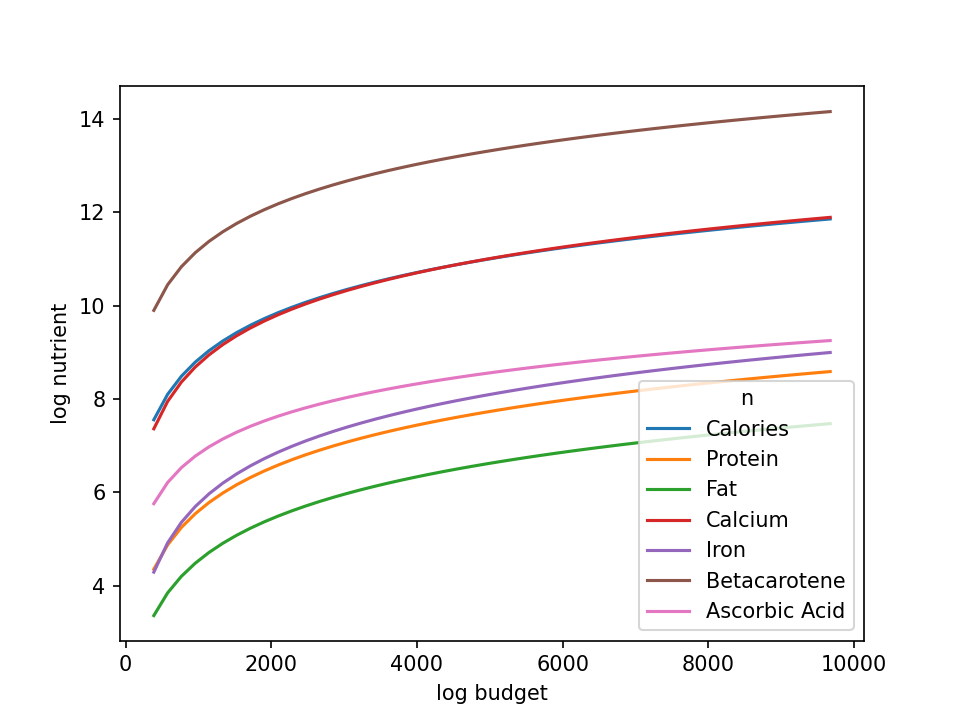

Text(0, 0.5, 'log nutrient')

In [20]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Calories','Protein','Fat','Calcium','Iron','Betacarotene','Ascorbic Acid']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



<IPython.core.display.Javascript object>


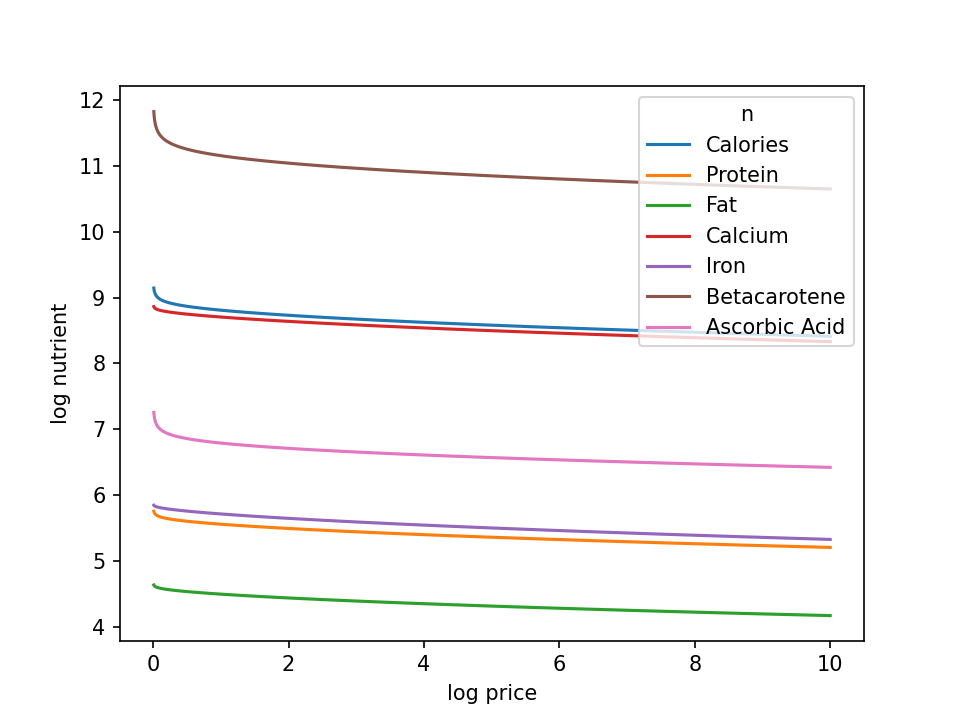

Text(0, 0.5, 'log nutrient')

In [29]:
USE_GOOD = 'potato'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [22]:
# In first round, averaged over households and villages
dbar = r.d.mean().iloc[:-3]
rdi

k,Females 0-1,Females 1-5,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 5-10,Females 50-60,Females 60-100,Males 0-1,Males 1-5,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 5-10,Males 50-60,Males 60-100
n,,,,,,,,,,,,,,,,,,
Calories,1205.00,1205.0,2170.00,2335.00,2230.0,2230.0,1520.00,2230.0,2230.0,1205.00,1205.0,2470.00,2875.00,2730.0,2730.0,1520.00,2730.0,2730.0
Protein,18.40,18.4,46.15,55.25,55.0,55.0,24.80,55.0,55.0,18.40,18.4,47.10,60.75,60.0,60.0,24.80,60.0,60.0
Fat,19.00,26.0,37.50,30.00,25.0,25.0,27.50,25.0,25.0,19.00,26.0,40.00,40.00,30.0,30.0,27.50,30.0,30.0
Calcium,500.00,600.0,800.00,1000.00,1200.0,1200.0,600.00,1200.0,1200.0,500.00,600.0,800.00,700.00,600.0,600.0,600.00,600.0,600.0
Iron,5.00,11.0,27.00,23.50,21.0,21.0,14.50,21.0,21.0,5.00,11.0,26.50,22.50,17.0,17.0,14.50,17.0,17.0
Betacarotene,2800.00,3200.0,4800.00,4800.00,4800.0,4800.0,4000.00,4800.0,4800.0,2800.00,3200.0,4800.00,4800.00,4800.0,4800.0,4000.00,4800.0,4800.0
Thiamine,0.25,0.6,1.10,1.05,1.1,1.1,0.75,1.1,1.1,0.25,0.6,1.25,1.45,1.4,1.4,0.75,1.4,1.4
Riboflavin,0.35,0.7,1.30,1.25,1.3,1.3,0.90,1.3,1.3,0.35,0.7,1.45,1.60,1.4,1.4,0.90,1.4,1.4
Niacin,9.50,9.5,13.50,14.00,14.0,14.0,12.00,14.0,14.0,9.50,9.5,15.50,17.50,18.0,18.0,12.00,18.0,18.0


Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [23]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar

hh_rdi

n
Calories          8855.176924
Protein            195.768486
Fat                111.798503
Calcium           3240.586723
Iron                73.377590
Betacarotene     17763.435657
Thiamine             4.420641
Riboflavin           4.888175
Niacin              57.821110
Ascorbic Acid      153.550582
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [24]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



/opt/conda/lib/python3.9/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.16E-10.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/opt/conda/lib/python3.9/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -2.91E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/opt/conda/lib/python3.9/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.46E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance i

<IPython.core.display.Javascript object>


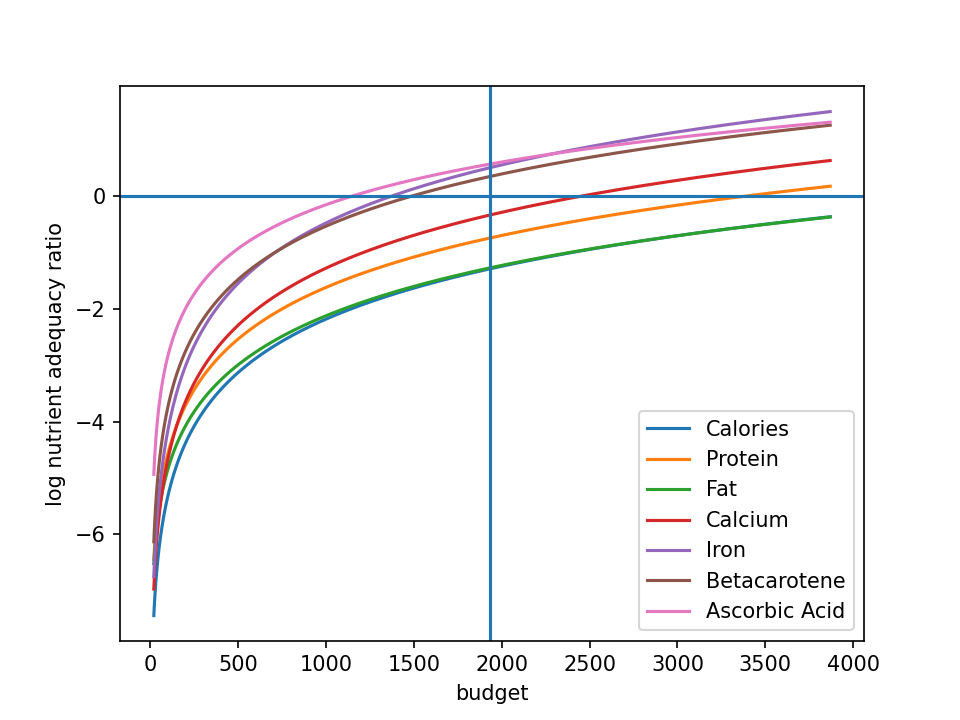

In [25]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



<IPython.core.display.Javascript object>


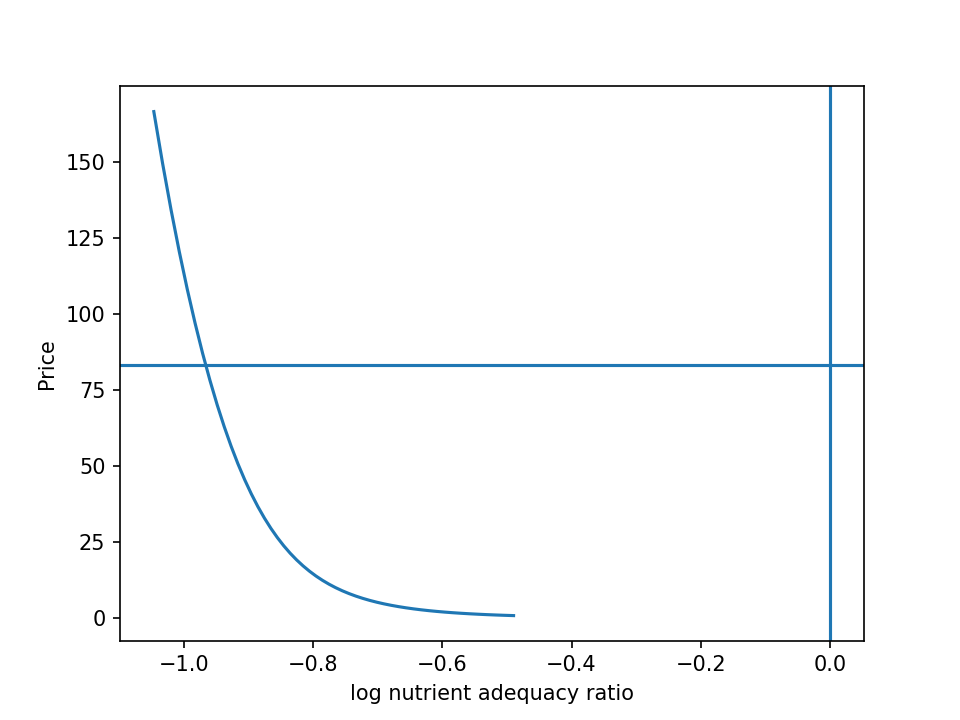

Text(0.5, 0, 'log nutrient adequacy ratio')

In [30]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Ascorbic Acid'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')